In [1]:
from kubernetes import config, client
from datetime import timezone, datetime
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

## Authenticate and set up kubectl API

In [2]:
# Run this cell to make sure kubectl is authenticated. If you get an error, debug w/ kubectl
!kubectl --namespace=prod get pod > /dev/null

In [3]:
CONTEXT = "gke_binder-prod_us-central1-a_prod-a"
NAMESPACE = "prod"
config.load_kube_config(context=CONTEXT)

# Get list of pods with given label selector in the 'prod' namespace
core_api = client.CoreV1Api()

pods = core_api.list_namespaced_pod(NAMESPACE, label_selector="component=singleuser-server")

## Parse data

In [4]:
data = []
for pod in pods.items:
    age = datetime.now(timezone.utc) - pod.status.start_time.replace(tzinfo=timezone.utc)
    data.append({'age': age.total_seconds() / 60, 'name': pod.metadata.name})

data = pd.DataFrame(data)

## Analyze!

Num matches: (141, 2)


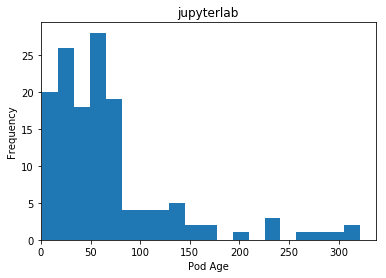

In [5]:
QUERY = 'jupyterlab'

print('Num matches: {}'.format(data[data['name'].map(lambda a: QUERY in a)].shape))

ax = data[data['name'].map(lambda a: 'jupyterlab' in a)]['age'].plot.hist(bins=20)
ax.set(xlim=[0, None], title=QUERY, xlabel='Pod Age');

In [6]:
data['repo_name'] = data['name'].map(lambda pod_name: '-'.join(pod_name.split("-")[:-1]))

## Plots and stats about pods from the last hour

In [7]:
# select only pods from the last 60minutes
recent_pods = data[data.age<60]
recent_pods.head()

,age,name,repo_name
0,14.880607,jupyter-4quantoss-2dfastphotostyle-2d6e06oucb,jupyter-4quantoss-2dfastphotostyle
2,29.047274,jupyter-allendowney-2dmodsimpy-2du5kdm3j0,jupyter-allendowney-2dmodsimpy
3,20.413941,jupyter-allendowney-2dthinkdsp-2dagt86noy,jupyter-allendowney-2dthinkdsp
5,38.330608,jupyter-amueller-2dintrod-2d-5fml-5fwith-5fpyt...,jupyter-amueller-2dintrod-2d-5fml-5fwith-5fpython
8,3.463941,jupyter-arash-2dash-2dprf-2de-2dation-2dtechni...,jupyter-arash-2dash-2dprf-2de-2dation-2dtechnique


In [8]:
# how often was each repo launched?
recent_pods.groupby("repo_name").count()

,age,name
repo_name,,
jupyter-4quantoss-2dfastphotostyle,1,1
jupyter-allendowney-2dmodsimpy,1,1
jupyter-allendowney-2dthinkdsp,1,1
jupyter-amueller-2dintrod-2d-5fml-5fwith-5fpython,1,1
jupyter-arash-2dash-2dprf-2de-2dation-2dtechnique,1,1
jupyter-artfisica-2dnotebooks,1,1
jupyter-binder-2dexamples-2djupyter-2dstacks,1,1
jupyter-binder-2dexamples-2djupyterlab,1,1
jupyter-binder-2dexamples-2dr,2,2


In [9]:
# names of repos that were launched more than five times
counts = recent_pods.groupby("repo_name").count()

idx = (counts > 5)['age']
popular_repos_names = counts.index[idx].tolist()

popular_pods = recent_pods[recent_pods.repo_name.isin(popular_repos_names)]

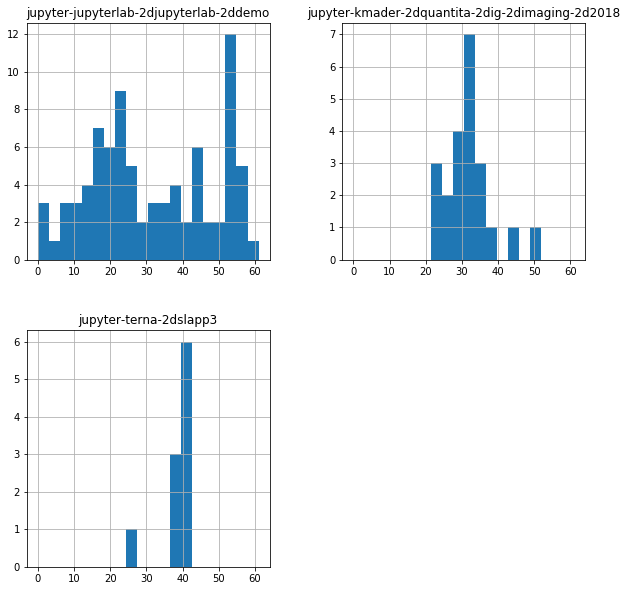

In [10]:
popular_pods.pivot(columns='repo_name', values='age').hist(bins=20, range=(0,61),
                                                           figsize=(10,10));
# Note: that pods with lower age are more recent, so these plots have an x axis which is
# "the wrong way around"